In [66]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy import *
from astropy.table import Table


%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


In [2]:
M = 1.16
P = 628.
year = 365.25
aearth = 1.
rsun = 6.957e8
au = 149597870700 # m

print rsun/au

0.00465046726096


In [3]:
const = aearth**3 / year**2

In [4]:
a = (P**2 * const)**(1/3.)
print a

1.43520171971


In [5]:
R = M**0.8
print R

1.12607260049


In [6]:
def L(M):
    logl = 4.328*np.log(M) -0.002
    return np.exp(logl)
    
print L(M)

1.89716711637


In [7]:
def teffpred(L,R):
    return 5777.*(L/R**2.)**0.25

print teffpred(L(M),R)

6389.18655302


In [8]:
def teq(Teff,Rstar,axis,f,A):
    '''Teff is star, R is stellar radius, a is semimajor axis, A is Bond albedo, f is the 
    geometric factor of reradiation'''
    
    return Teff*np.sqrt(Rstar*rsun/2./(axis*au))*(f*(1.-A))**0.25

In [9]:
tstar = teffpred(L(M),R)

In [10]:
tplan = teq(tstar,R,a,2.0,0.5)
print tplan

272.901290532


In [11]:
L(M)/(a**2)

0.92104255464806839

In [12]:
R

1.1260726004890476

In [13]:
## earth

Tearth = teq(5777,1.,1.,2.0,0.29)
print Tearth

304.093930109


In [14]:
tvenus = teq(5770,1.,0.72,1.0,0.6)
print tvenus

260.770140262


In [15]:
mas2rad = 1000*3600*180./np.pi

In [16]:
## today

giant_teff = 3934.

distance = 19.34 # pc
angular = 20.58e-3
print angular

linear = angular*distance*(au)/rsun



0.02058


In [17]:
tgiant = teq(giant_teff,linear,a,2.0,0.5)

In [18]:
tgiant

1464.9196508550642

## Now let's use MCMC to get uncertainties on these. We have uncertainties in mass and everthing else is derived from scaling relations.

In [19]:
nmass = 10000
masses = 1.16 + np.random.randn(nmass)*0.07

In [20]:
ells = L(masses)
arrs = masses**0.8

teffs = teffpred(ells,arrs)

In [21]:
const = aearth**3 / year**2

In [22]:
axes = (P**2 * const*masses)**(1/3.)

In [23]:
teqs = teq(teffs,arrs,axes,2.,0.29)


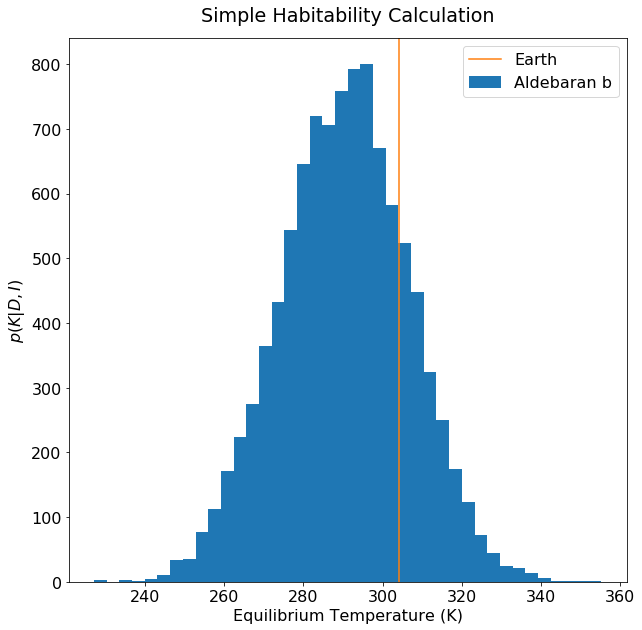

In [24]:
h = plt.hist(teqs,bins=40,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('Simple Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [25]:
print np.mean(teqs), np.std(teqs)

290.361278592 16.2224169599


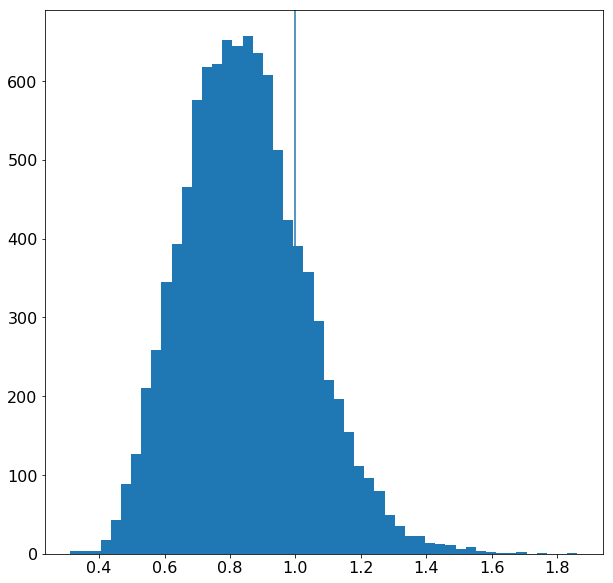

In [26]:
h = plt.hist(ells/axes**2.,bins=50)
plt.axvline(1.0)

In [27]:
print np.mean(ells/(axes**2.)), np.std(ells/(axes**2.))

0.846808462314 0.188257872082


In [28]:
print np.mean(ells), np.std(ells)

1.94108391091 0.510489630799


In [29]:
print np.mean(axes), np.std(axes)

1.50694392263 0.0307472706643


## Let's do this with proper stellar models

In [30]:
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

In [31]:
%%time
rad = mist.radius(M,6.,-0.3)

CPU times: user 5.09 s, sys: 2.76 s, total: 7.85 s
Wall time: 8.1 s


In [32]:
rad

2.4409202906989584

In [33]:
t = np.linspace(9.8,11.,1000)
t = np.log10(np.linspace(1e6,15e9,1000))
numaxes = mist.nu_max(1.,t,0.0)
radii = mist.radius(1.,t,0.0)

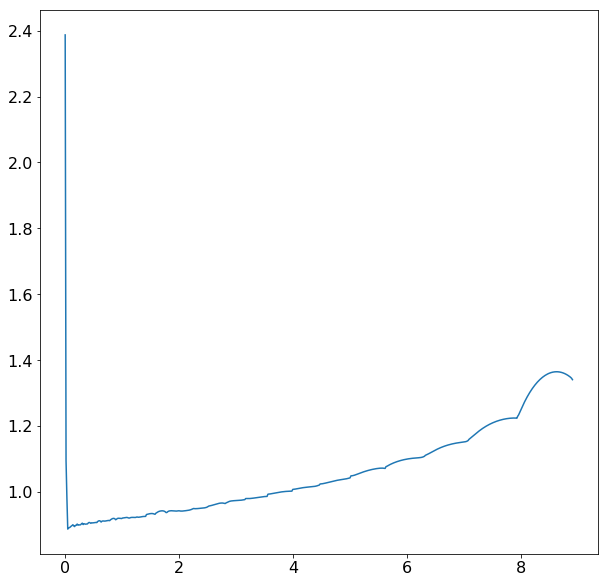

In [34]:
# plt.plot(t,numaxes)
plt.plot(10**t/1e9,radii)

In [35]:
t = np.log10(1.e9*np.linspace(0.2,7.,2000))

rr = mist.radius(M,t,-0.15)

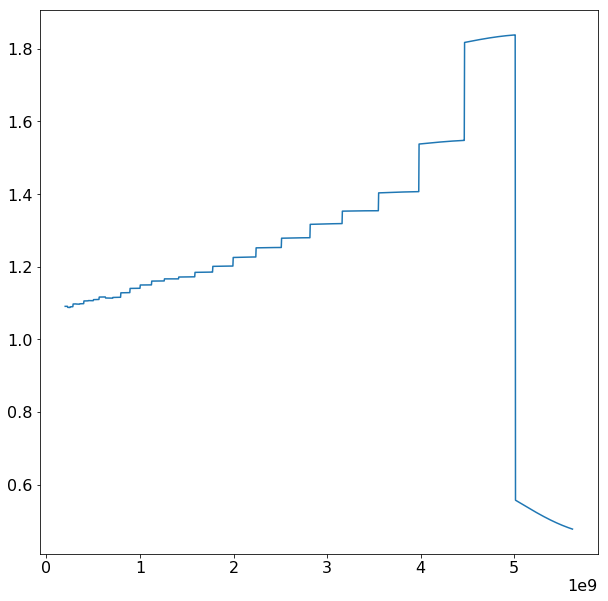

In [36]:
plt.plot(10**t,rr)

In [37]:
### ok now do aldebaran
fehs = -0.15 + 0.2*np.random.randn(nmass)
radii = mist.radius(masses,np.log10(2.e9),fehs)
logLs = mist.logL(masses,np.log10(2.e9),fehs)

In [38]:
ells2 = 10**logLs

In [39]:
ells2.shape

(10000,)

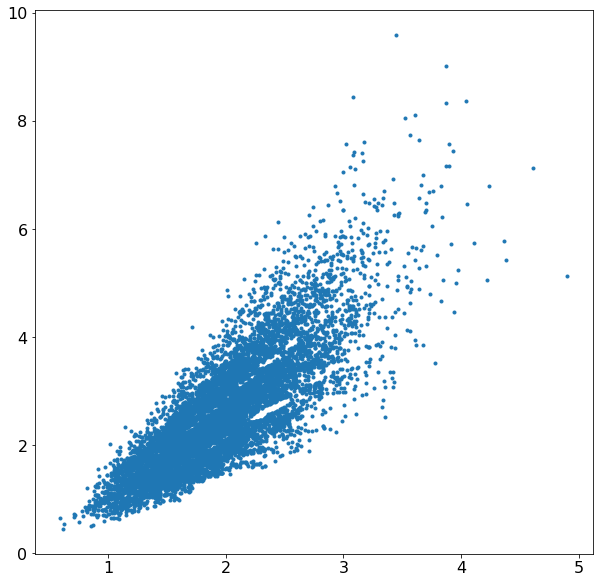

In [40]:
plt.plot(ells,ells2,'.')

In [68]:
times = np.linspace(0.5,4.5,50.)
means, stds = [], []
meanells, stdells = [], []
uppers, lowers = [], []

fehs = -0.15 + 0.2*np.random.randn(nmass)

for t in times:
    radii = mist.radius(masses,np.log10(t*1.e9),fehs)
    logLs = mist.logL(masses,np.log10(t*1.e9),fehs)
    ells2 = 10**logLs
    meanells.append(np.nanmean(ells2))
    stdells.append(np.nanstd(ells2))
    
    ratios = ells2/axes**2.
    ratios = ratios[np.isfinite(ratios)]
    upper = np.percentile(ratios,50+34.1)
    lower = np.percentile(ratios,50-34.1)
    
    means.append(np.nanmean(ratios))
    stds.append(np.nanstd(ratios))
    uppers.append(upper)
    lowers.append(lower)
    
means = np.array(means)
stds = np.array(stds)
uppers = np.array(uppers)
lowers = np.array(lowers)

/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [69]:
print means

[ 0.86285548  0.87813999  0.88690845  0.89765628  0.91034765  0.92393503
  0.92577831  0.94091914  0.95801313  0.96032697  0.97981984  0.98196948
  1.00409287  1.00657129  1.03257924  1.0352809   1.06589167  1.06848014
  1.0710852   1.10633733  1.10932834  1.11213615  1.15477103  1.15840343
  1.1620629   1.21217238  1.21612842  1.22063438  1.22467269  1.29137994
  1.29862269  1.30752701  1.31690454  1.37426148  1.38430906  1.39728909
  1.41272114  1.43029993  1.47225393  1.48722246  1.50612517  1.52833732
  1.55296794  1.54607071  1.56544984  1.59204538  1.62513412  1.66439285
  1.70592028  1.55684198]


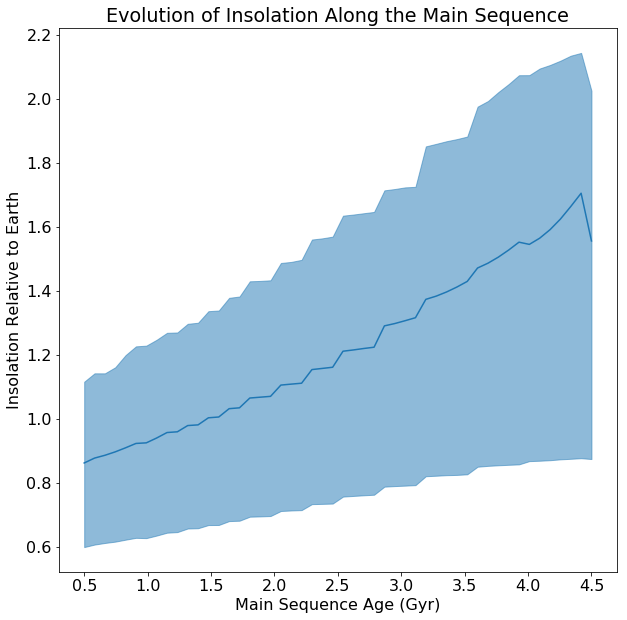

In [70]:
# plt.plot(times,means,'x')
# plt.errorbar(times,means,yerr=stds,linestyle='none')
plt.plot(times,means,'-')
plt.fill_between(times,lowers,uppers,color=colours[0],alpha=0.5)
plt.xlabel('Main Sequence Age (Gyr)')
plt.ylabel('Insolation Relative to Earth')
plt.title('Evolution of Insolation Along the Main Sequence')
plt.savefig('insolation.png')

<Container object of 3 artists>

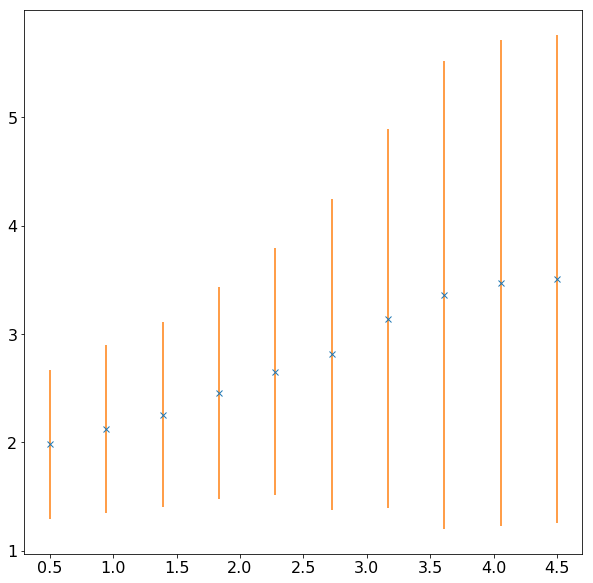

In [44]:
plt.plot(times,meanells,'x')
plt.errorbar(times,meanells,yerr=stdells,linestyle='none')

In [45]:
print meanells[0], stdells[0]
print meanells[-1], stdells[-1]

1.981850225 0.688289656149
3.51002457746 2.25223082837


In [46]:
print means[0], stds[0]
print means[-1], stds[-1]

0.863608068156 0.269726547226
1.55857576862 0.971372958405


In [47]:
print axes.mean()
print axes.std()

1.50694392263
0.0307472706643


In [48]:
ratios.max()

12.300258003272219

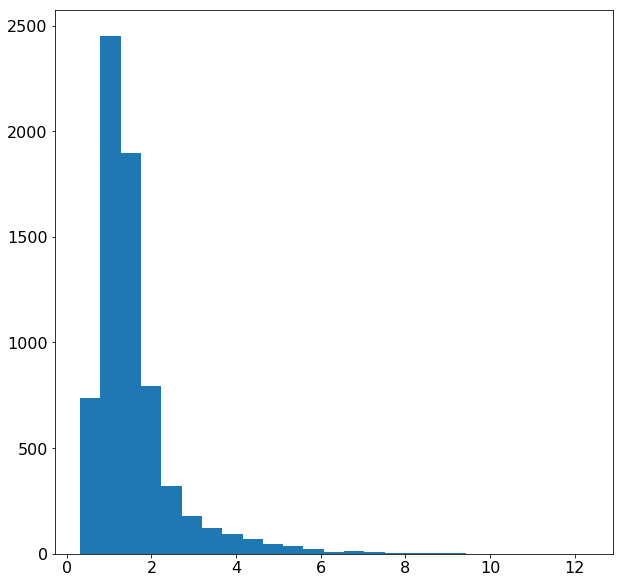

In [49]:
k = plt.hist(ratios,bins=25)
# plt.axvline(1.0,color=colours[1])

ValueError: max must be larger than min in range parameter.

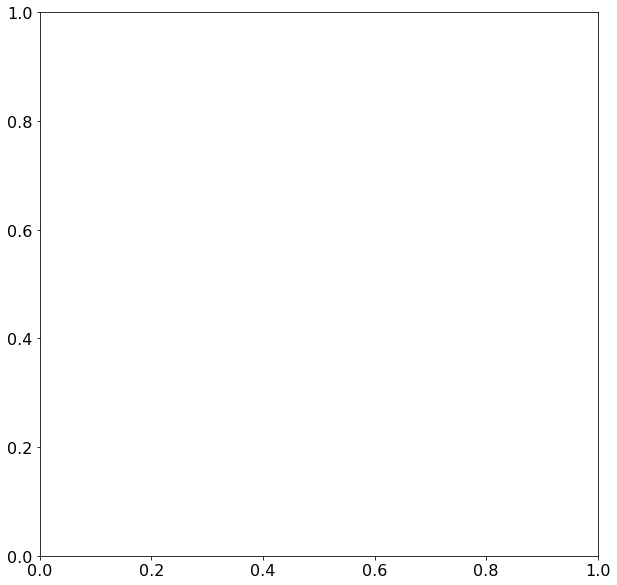

In [50]:
h = plt.hist(ells2/ells,bins=100)
print np.mean(ells2/ells), np.std(ells2/ells)

In [ ]:
print np.mean(ells2/(axes**2.)), np.std(ells2/(axes**2.))

In [ ]:
# arrs2 = mist.radius(masses,np.log10(2e9),-0.34)
arrs2 = mist.radius(masses,np.log10(1e9),-0.15)

In [ ]:
teffs2 = teffpred(ells2,arrs2)

In [ ]:
teqs = teq(teffs2,arrs2,axes,2.,0.29)


In [ ]:
h = plt.hist(teqs,bins=25,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('MIST Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [179]:
print np.mean(teqs), np.std(teqs)

303.613769922 12.4526148846


In [157]:
Tearth

304.09393010897196